In [1]:
%cd ../..

C:\Work\Modern Time Series Forecasting _ 2E\Modern-Time-Series-Forecasting-with-Python-2E


### Installing NGBoost (if not installed)

In [2]:
# %%capture
# !pip install -q ngboost

### Common Imports

In [3]:
import numpy as np
import pandas as pd

### Common Functions and metrics

- The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.Importing it from `src/utils/plotting_utils.
- `average_length` isn't implemented in `utilsforecast`, and therefore we have implemented it the same way as the rest of the metrics. Importing it from `src/utils/ts_utils.py`.
- `level_to_quantiles` is a function that converts a level to a quantile. Importing it from `src/utils/ts_utils.py`.

In [4]:
from src.utils.ts_utils import average_length, level_to_quantiles
from src.utils.plotting_utils import plot_grid

### Loading M4 Data

Let's load the data and pick 8 time series to work with.

In [5]:
from src.utils.general import download_m4_data
import os
if not os.path.exists('data/m4/M4-Hourly.csv'):
    download_m4_data()
Y_train_df = pd.read_csv('data/m4/M4-Hourly.csv')
Y_test_df = pd.read_csv('data/m4/M4-Hourly-test.csv')#.rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long.

In [7]:
# Taking first n_series time series from the dataset
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

### Plotting Sampled TS

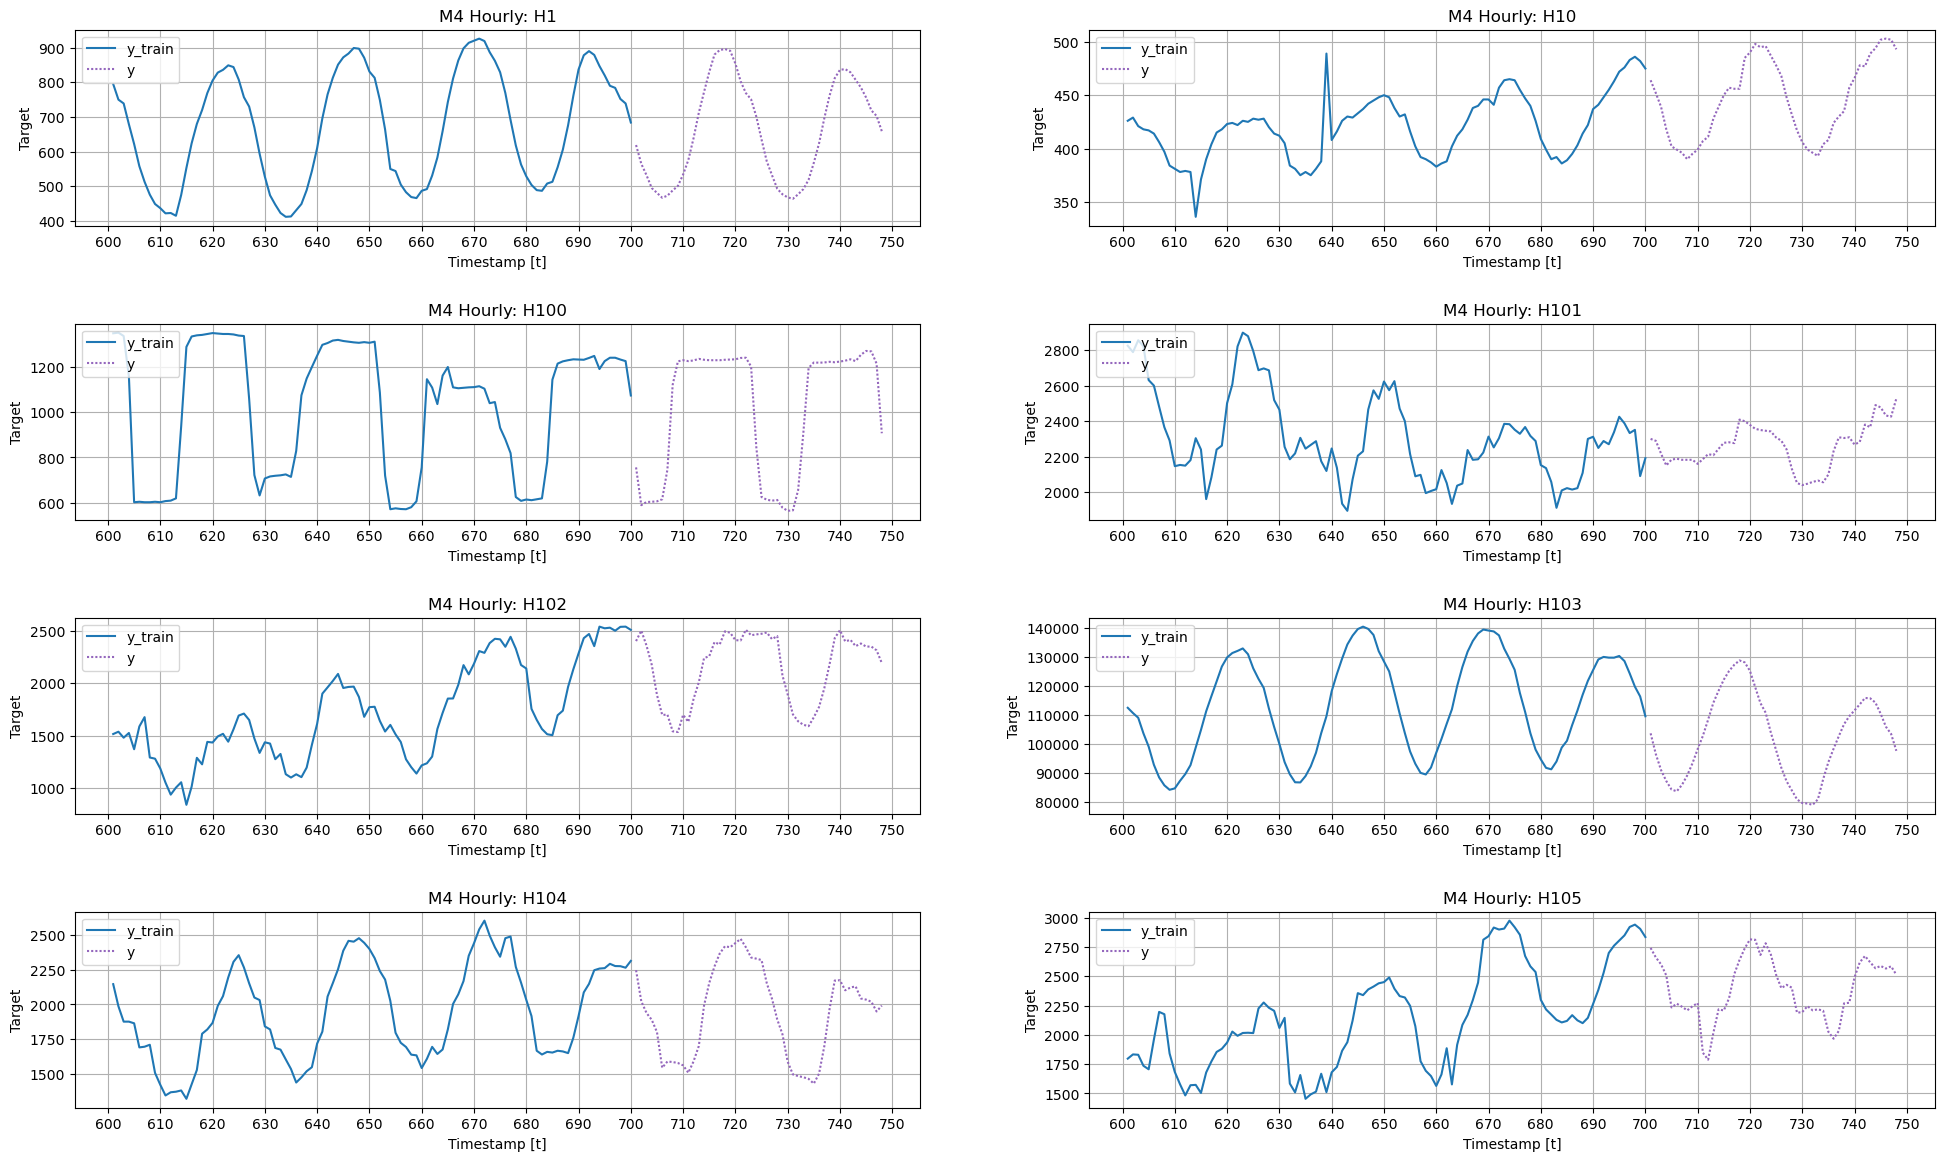

In [31]:
# Plotting the selected time series
plot_grid(Y_train_df, Y_test_df)

### Adding a few features we learned to make this into a regression problem

In [9]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean, Offset

In [10]:
data = pd.concat([Y_train_df, Y_test_df], ignore_index=True)

In [11]:
fcst = MLForecast(
    models=[],
    freq=24,  # Freq as 24 because we have hourly data
    lags=[1,2,3,4, 7], # Defining the Lags we need to create
    # Defining some transformations we need to do to the lags (offsets)
    lag_transforms={
        1: [ExpandingMean(), RollingMean(window_size=7, min_samples=1), RollingMean(window_size=14)],
    },
)
data = fcst.preprocess(data)
data.head()

,unique_id,ds,y,lag1,lag2,lag3,lag4,lag7,expanding_mean_lag1,rolling_mean_lag1_window_size7_min_samples1,rolling_mean_lag1_window_size14
14,H1,15,493.0,455.0,420.0,397.0,383.0,395.0,465.285714,400.285714,465.285714
15,H1,16,554.0,493.0,455.0,420.0,397.0,382.0,467.133333,414.285714,457.285714
16,H1,17,610.0,554.0,493.0,455.0,420.0,370.0,472.562500,438.857143,455.000000
17,H1,18,666.0,610.0,554.0,493.0,455.0,383.0,480.647059,473.142857,456.714286
18,H1,19,715.0,666.0,610.0,554.0,493.0,397.0,490.944444,513.571429,464.357143


### NGBoost

In [12]:
from ngboost import NGBRegressor
from ngboost.distns import Normal

In [13]:
# Splitting Train and Val after feature engineering
val_dates = Y_test_df.ds.unique()

train = data[~data['ds'].isin(val_dates)]
val = data[data['ds'].isin(val_dates)]
train_keys = train[["unique_id", 'ds']]
val_keys = val[["unique_id", 'ds']]
train = train.drop(['unique_id', 'ds'], axis=1)
val = val.drop(['unique_id', 'ds'], axis=1)
X_train, Y_train = train.drop(['y'], axis=1), train['y']
X_val, Y_val = val.drop(['y'], axis=1), val['y']

#### Training

In [14]:
# Training the model
levels = [80, 90]
ngb = NGBRegressor(Dist=Normal, random_state=42).fit(X_train, Y_train)

[iter 0] loss=11.8343 val_loss=0.0000 scale=2.0000 norm=43432.6733
[iter 100] loss=10.5190 val_loss=0.0000 scale=2.0000 norm=5760.0220
[iter 200] loss=9.1240 val_loss=0.0000 scale=4.0000 norm=1162.9574
[iter 300] loss=7.2651 val_loss=0.0000 scale=4.0000 norm=714.5449
[iter 400] loss=6.4730 val_loss=0.0000 scale=2.0000 norm=323.1752


#### Inference

In [15]:
# Point Forecast
y_pred = ngb.predict(X_val)
y_pred[:10]

array([678.91150198, 642.15902215, 561.9840091 , 536.34067336,
       502.84042003, 485.57066773, 478.89010348, 490.13804083,
       508.1088736 , 508.1088736 ])

In [16]:
# Probabilistic Forecast
# Getting the parameters of the assumed distribution
y_pred_dists = ngb.pred_dist(X_val)
# First five datapoint predicted parameters
y_pred_dists[0:5].params

{'loc': array([678.91150198, 642.15902215, 561.9840091 , 536.34067336,
        502.84042003]),
 'scale': array([77.17515487, 77.22207565, 66.03839707, 66.08494412, 61.39341574])}

In [17]:
# Prediction Interval with confidence
y_pred_lower, y_pred_upper = y_pred_dists.dist.interval(0.95)

Generating predictions and assigning them back to standard format

In [18]:
# Point Forecast
Y_test_df['NGBoost'] = ngb.predict(X_val)

for l in levels:
    # Prediction Interval with confidence
    y_pred_lower, y_pred_upper = y_pred_dists.dist.interval(l/100)
    Y_test_df[f'NGBoost-lo-{l}'] = y_pred_lower
    Y_test_df[f'NGBoost-hi-{l}'] = y_pred_upper
Y_test_df.head()

,unique_id,ds,y,NGBoost,NGBoost-lo-80,NGBoost-hi-80,NGBoost-lo-90,NGBoost-hi-90
0,H1,701,619.0,678.911502,580.007561,777.815443,551.969669,805.853335
1,H1,702,565.0,642.159022,543.194950,741.123094,515.140011,769.178033
2,H1,703,532.0,561.984009,477.352398,646.615620,453.360512,670.607506
3,H1,704,495.0,536.340673,451.649410,621.031937,427.640613,645.040733
4,H1,705,481.0,502.840420,424.161592,581.519248,401.857237,603.823603


#### Plotting

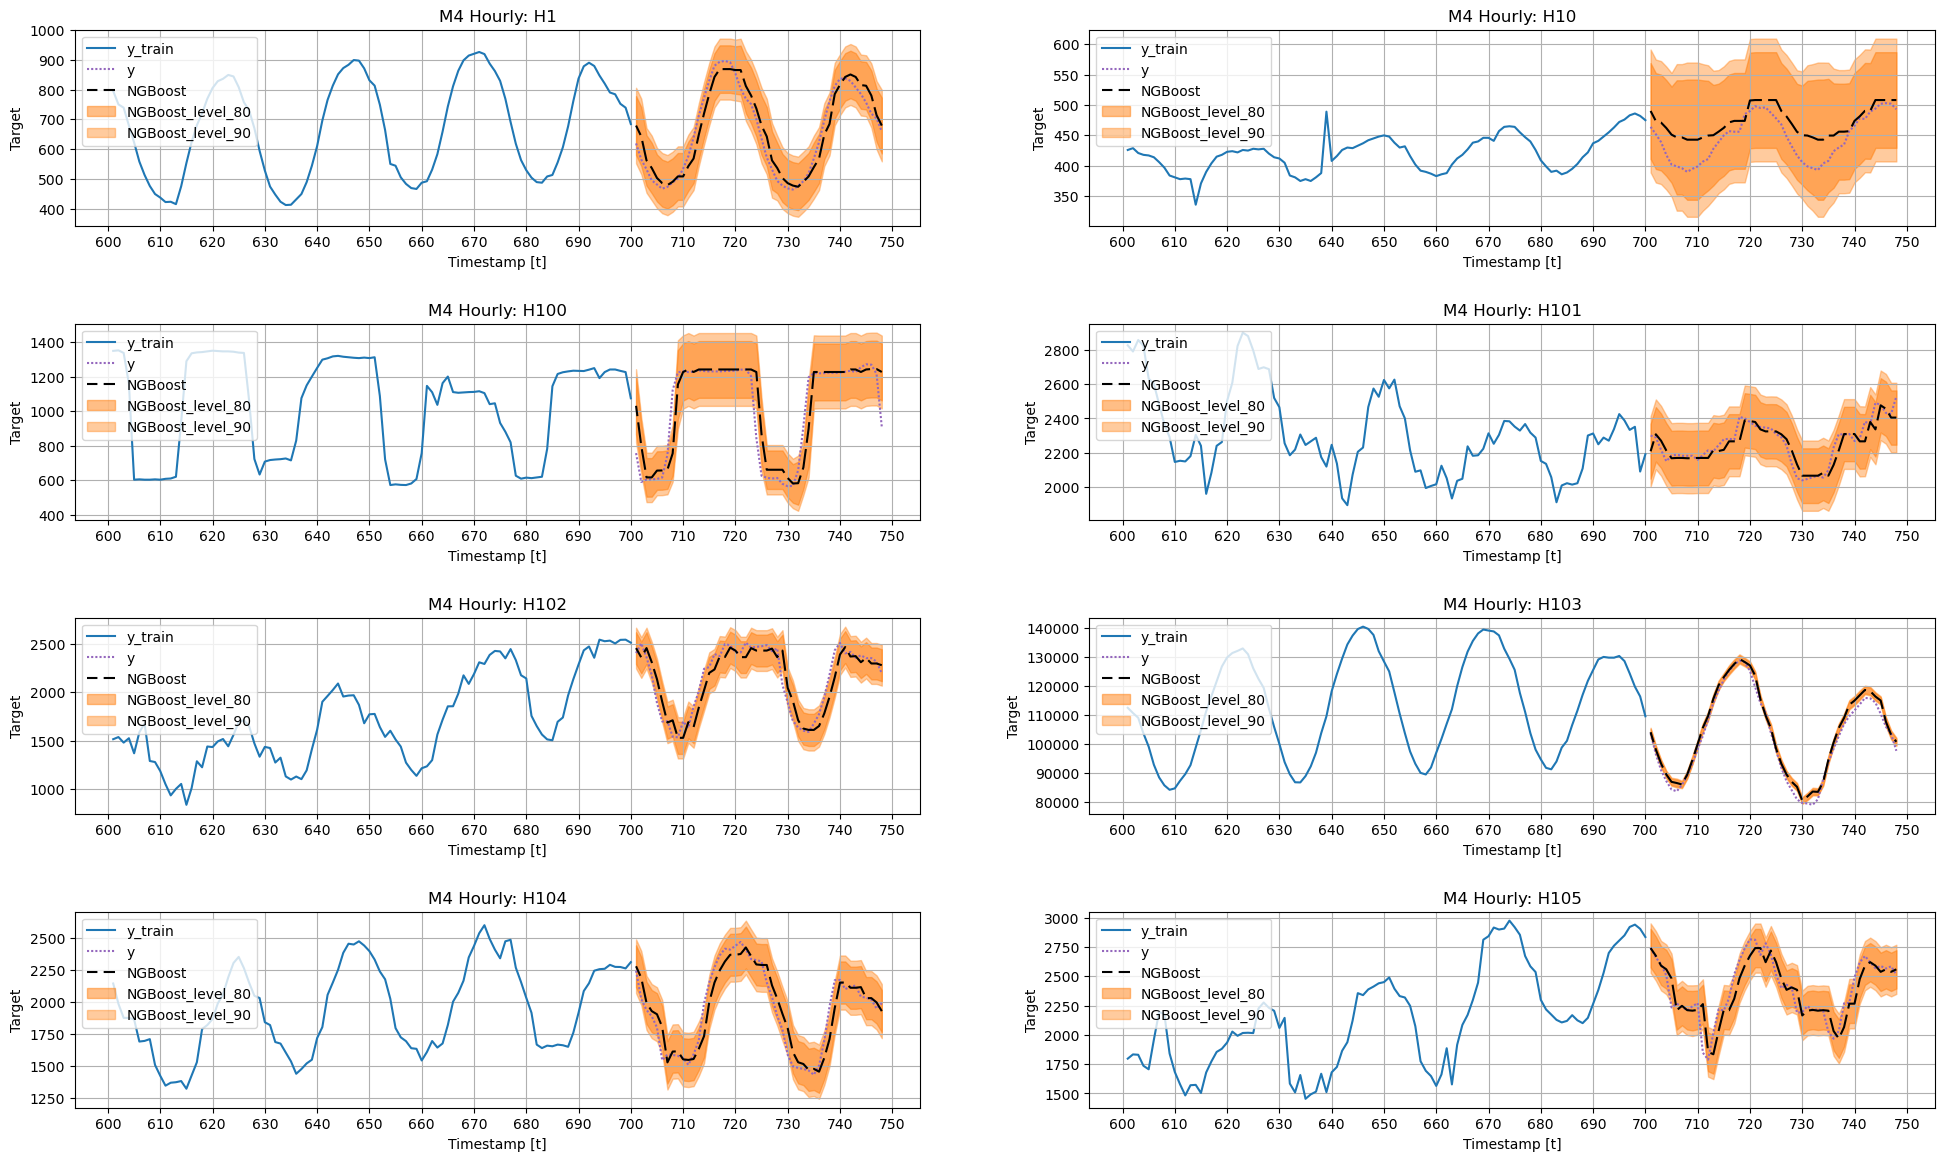

In [32]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='NGBoost')

#### Metrics

In [20]:
from utilsforecast.losses import mae, coverage

In [21]:
res_df = mae(Y_test_df, models=['NGBoost']).rename(columns={'NGBoost': 'NGBoost-mae'})
for l in levels:
    res_df = res_df.merge(coverage(Y_test_df, models=['NGBoost'], level=l).rename(columns={'NGBoost': f'NGBoost-coverage-{l}'}), on='unique_id')
    res_df = res_df.merge(average_length(Y_test_df, models=['NGBoost'], level=l).rename(columns={'NGBoost': f'NGBoost-average_length-{l}'}), on='unique_id')
res_df

,unique_id,NGBoost-mae,NGBoost-coverage-80,NGBoost-average_length-80,NGBoost-coverage-90,NGBoost-average_length-90
0,H1,33.446126,1.000000,167.524616,1.000000,215.015517
1,H10,26.330457,1.000000,166.351375,1.000000,213.509679
2,H100,67.937080,0.833333,302.439255,0.833333,388.176581
3,H101,37.364603,1.000000,318.001374,1.000000,408.150345
4,H102,102.209607,0.750000,328.523550,0.895833,421.655412
5,H103,1932.872853,0.291667,2326.816546,0.395833,2986.436705
6,H104,80.912530,0.875000,329.550064,0.916667,422.972928
7,H105,85.117678,0.812500,329.116238,0.937500,422.416119
